# Project Report: Which is the PULSAR
**DSCI 100 (007-34) Group Project Report**  
Group members:
- Elliot Saha
- Alasdair Buchanan
- Sarah Trevisan
- Minghao Li

## 1. Introduction

### 1.1 Background Information
Pulsars are high-magnetized neutron stars that spin at accurately constant speeds (Wikimedia Foundation, 2024). Because of this unique property, they are widely used in scientific research. However, it can be very challenging to identify their signals due to space noises.

### 1.2 Research Question
Our research question is:  
**Which candidate star will be a pulsar? How can we identify a pulsar given its radiation profile?**


### 1.3 Dataset
We will use [HTRU2 dataset](https://archive.ics.uci.edu/dataset/372/htru2) to classify pulsar stars. The dataset contains `Integrated Profile` and `DM-SNR curve` records for pulsar candidates.

- `Integrated profile` is a continuous sequence of measurements that describes the pulse signal received over time.
- `DM-SNR curve` is the curve showing the signal-to-noise ratio between the pulse and background radiation emissions.  
The author of this dataset compressed these arrays into 8 single variables (mean, standard deviation, kurtosis, and skewness for each of these two arrays).

## 2. Methods & Results
In this section, we will talk about our analysis process.

### 2.1 Method
Firstly, we will import all the necessary libraries and set a random seed to make sure the report is reproducible.

In [1]:
# import necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(modeldata)
install.packages("themis")
library(themis)
# set random seed
set.seed(1111)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Download data from our GitHub repository.

In [2]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/Lmh-java/dsci-100-2023w2-group-034/main/data/HTRU_2.csv", col_names=FALSE)
sprintf("Table 1: ")
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


#### 2.1.1 Data Wrangling
After the data is read from the source, we need to wrangle it for future analysis.

In [3]:
# rename the columns according to data/Readme.txt
pulsar_data <- pulsar_data |>
    rename(profile_mean = X1,
          profile_sd = X2,
          profile_kurtosis = X3,
          profile_skewness = X4,
          DM_SNR_mean = X5,
          DM_SNR_sd = X6,
          DM_SNR_kurtosis = X7,
          DM_SNR_skewness = X8,
          pulsar_star = X9) |> 
          # mark the label column as a categorical variable
          mutate(pulsar_star = as_factor(pulsar_star)) |>
          # pulsar_star refers to if the row is a pulsar star or not
          mutate(pulsar_star = fct_recode(pulsar_star, "true" = "1", "false" = "0"))
sprintf("Table 2: ")
head(pulsar_data)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,false
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,false
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,false
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,false
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,false


In [4]:
# We divide the dataset into training and testing subsets. The training set is 70% of the entire dataset, while the testing set takes the other 30%.
pulsar_split <- initial_split(pulsar_data, prop = 0.7, strata = pulsar_star)  
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)
sprintf("Table 3: ")
head(pulsar_train)
head(pulsar_test)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,false
136.7500,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,false
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,false
130.3828,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,false
107.2500,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,false
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,false


profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


`pulsar_train` is the cleaned training dataset for training our model. `pulsar_test` is the cleaned testing dataset for evaluating the final model. We need to summarize the training data to get a better insight for building the model. Firstly, we need to gather some basic information about the training data.
#### 2.1.2 Summary of Data

In [5]:
sprintf("Table 4: ")
glimpse(pulsar_train)

Rows: 12,528
Columns: 9
$ profile_mean     <dbl> 102.50781, 136.75000, 119.48438, 130.38281, 107.25000…
$ profile_sd       <dbl> 58.88243, 57.17845, 48.76506, 39.84406, 52.62708, 39.…
$ profile_kurtosis <dbl> 0.46531815, -0.06841464, 0.03146022, -0.15832276, 0.4…
$ profile_skewness <dbl> -0.51508791, -0.63623837, -0.11216757, 0.38954045, 0.…
$ DM_SNR_mean      <dbl> 1.6772575, 3.6429766, 0.9991639, 1.2207358, 2.3319398…
$ DM_SNR_sd        <dbl> 14.860146, 20.959280, 9.279612, 14.378941, 14.486853,…
$ DM_SNR_kurtosis  <dbl> 10.576487, 6.896499, 19.206230, 13.539456, 9.001004, …
$ DM_SNR_skewness  <dbl> 127.39358, 53.59366, 479.75657, 198.23646, 107.97251,…
$ pulsar_star      <fct> false, false, false, false, false, false, false, fals…


The training dataset has 12,528 rows and 9 columns (including the target label)  
Secondly, we need to ensure there are no `NA` values in the training dataset.

In [6]:
sprintf("Number of NAs: %s", sum(is.na(pulsar_train)))

[1] "Number of NAs: 0"

As shown above, there is no `NA` value in the dataset. Next, we need to take a look at the category distribution of the training set.

In [7]:
num_observations <- pulsar_train |>
    group_by(pulsar_star) |>
    summarize(num = n())
sprintf("Table 5: ")
num_observations

pulsar_star,num
<fct>,<int>
false,11400
true,1128


In the training set, the category `false` has 11400 observations, while the category `true` only has 1128 observations. Therefore, we must resample the training set to avoid model bias.  
Next, we will take a look at the average of each predictor.

In [36]:
avg_predictors <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    group_by(variable) |>
    summarize(average = mean(value, na.rm=TRUE))
sprintf("Table 6: ")
avg_predictors

[1] "Table 2: "

variable,average
<chr>,<dbl>
DM_SNR_kurtosis,8.2914408
DM_SNR_mean,12.4725362
DM_SNR_sd,26.2517152
DM_SNR_skewness,104.1450850
profile_kurtosis,0.4679873
profile_mean,111.3858407
profile_sd,46.6058129
profile_skewness,1.7283891


The average of predictors varies in a range from 0.468 to 111.386. This means some predictors are very spread out, so we must normalize the values before feeding the data to the model.
#### 2.1.3 Data Visualization

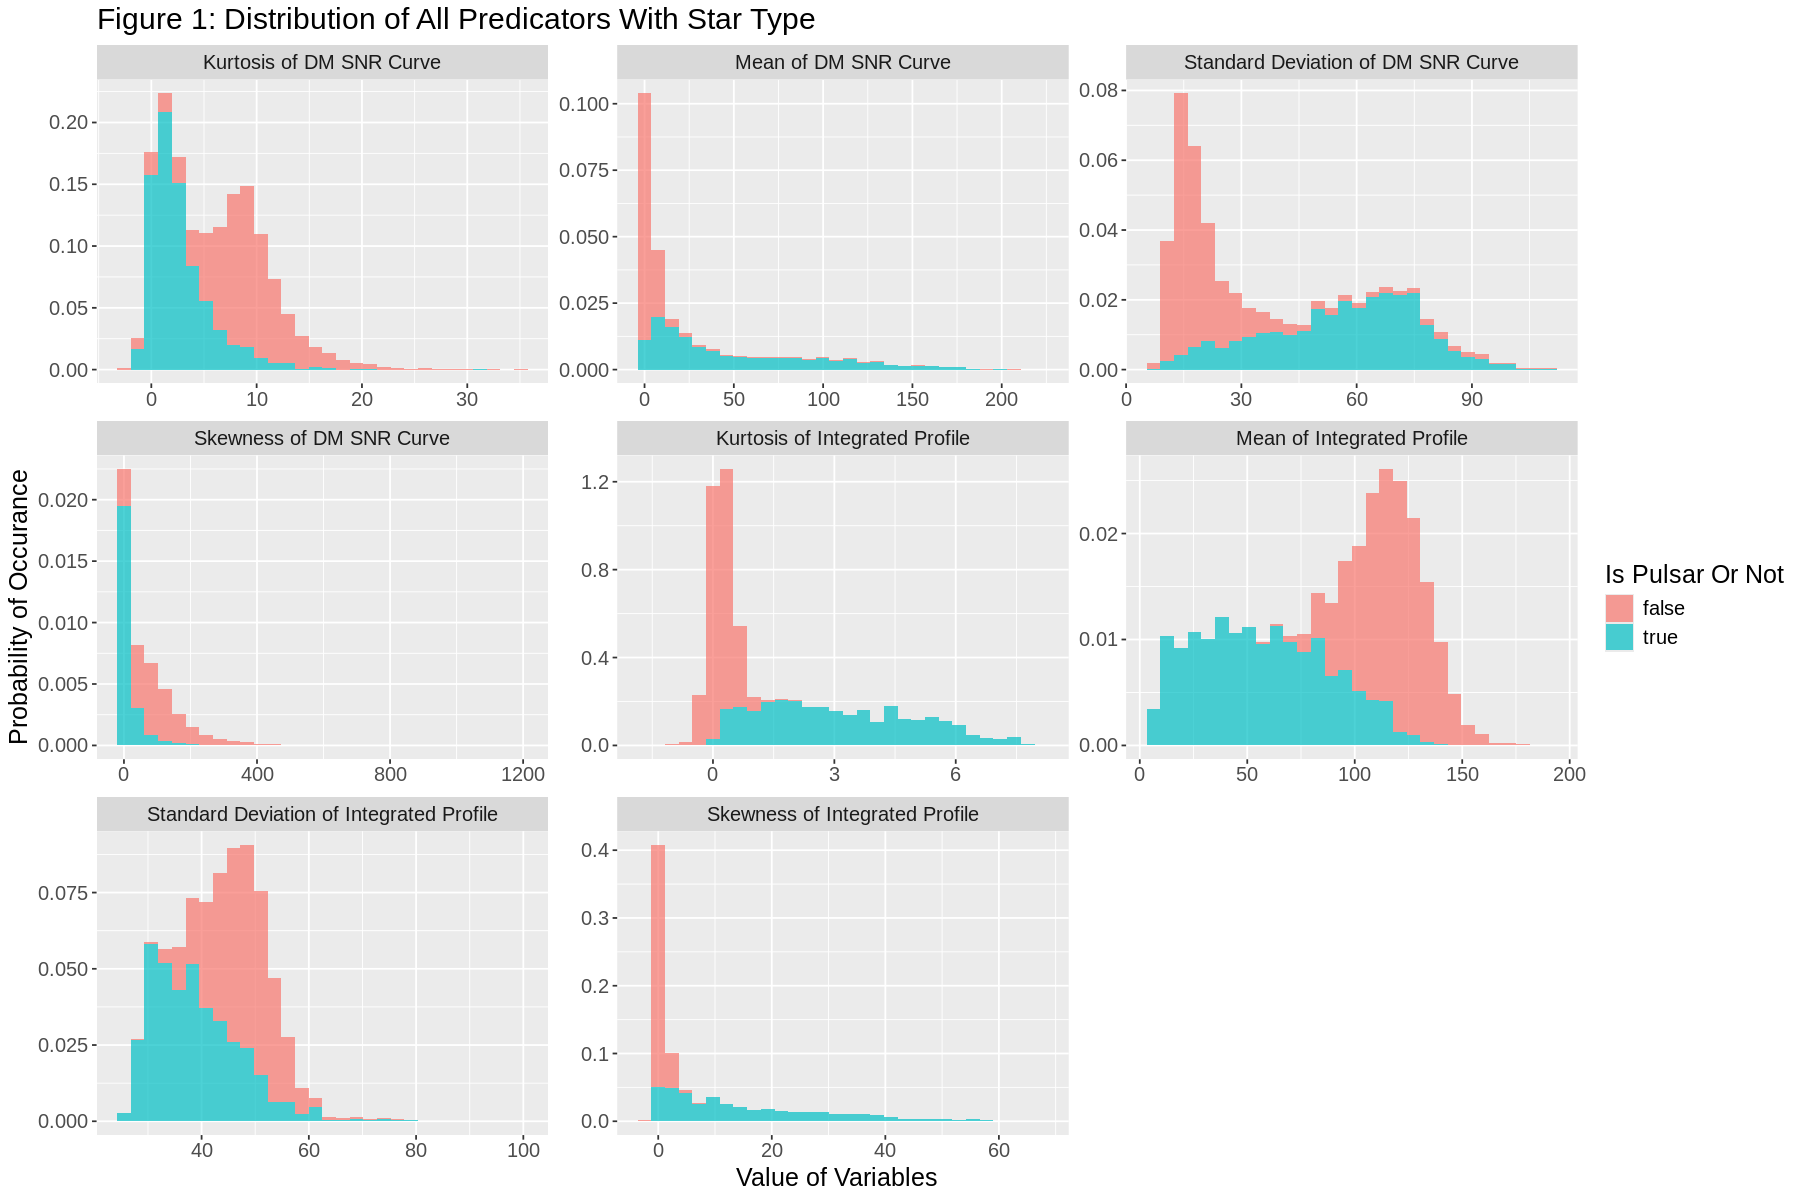

In [39]:
options(repr.plot.width = 15, repr.plot.height=10)

readable_var_names = c("DM_SNR_kurtosis" = "Kurtosis of DM SNR Curve", "DM_SNR_mean" = "Mean of DM SNR Curve", 
                       "DM_SNR_sd" = "Standard Deviation of DM SNR Curve", "DM_SNR_skewness" = "Skewness of DM SNR Curve", "profile_kurtosis" = "Kurtosis of Integrated Profile", 
                       "profile_mean" = "Mean of Integrated Profile", "profile_sd" = "Standard Deviation of Integrated Profile", "profile_skewness" = "Skewness of Integrated Profile")
distribution_plot <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    ggplot(aes(x = value, fill = pulsar_star, y = after_stat(density))) +
    geom_histogram(bins=30, alpha=0.7) +
    facet_wrap(vars(variable), scales = "free", labeller=labeller(variable = readable_var_names)) +
    theme(text = element_text(size=15)) +
    labs(x = "Value of Variables", y = "Probability of Occurance", fill = "Is Pulsar Or Not") +
    ggtitle("Figure 1: Distribution of All Predicators With Star Type")
    
distribution_plot

In Figure 1, we plotted the distribution of every predictor separated by different label types. The red color marks the observations that are not pulsars, while the blue color marks the observations that are pulsars. We can use all the predictors for training the model since the distribution of these two labels is sufficiently different from each other, so the model can capture this difference to make better predictions.

#### 2.1.4 Model Training
Now, we have collected enough information about the dataset. It is the time to start training the model. We decided to use **K-nearest neighbors model** to perform the classification task.

Since there is a serious class imbalance in the training set, we need to resample it to balance class labels. To reduce the computational expense in the training process, we decided to use downsampling.

In [37]:
# Downsample the data
downsample_recipe <- recipe(pulsar_star ~ ., data=pulsar_train) |>
    step_downsample(pulsar_star, under_ratio=1) |>
    prep()

pulsar_train_downsampled <- downsample_recipe |>
    bake(new_data=NULL)

sprintf("Table 7: ")
glimpse(pulsar_train_downsampled)
sprintf("Table 8: ")
count(pulsar_train_downsampled, pulsar_star)

[1] "Table 7: "

Rows: 2,256
Columns: 9
$ profile_mean     <dbl> 133.21094, 102.32812, 146.48438, 87.10938, 127.39062,…
$ profile_sd       <dbl> 53.35738, 41.16224, 50.37577, 36.06055, 51.00632, 48.…
$ profile_kurtosis <dbl> -0.11152482, 0.11953742, -0.49618395, 0.73766435, -0.…
$ profile_skewness <dbl> -0.392228929, 0.918116991, 0.013135363, 2.716326969, …
$ DM_SNR_mean      <dbl> 8.0693980, 3.0660535, 73.6973244, 2.5618729, 4.088628…
$ DM_SNR_sd        <dbl> 38.62318, 16.79146, 89.85929, 19.75985, 21.36771, 26.…
$ DM_SNR_kurtosis  <dbl> 4.8052421, 8.1431616, 0.6629511, 8.7717689, 6.2524131…
$ DM_SNR_skewness  <dbl> 22.025768, 83.256992, -1.248639, 82.965440, 44.061311…
$ pulsar_star      <fct> false, false, false, false, false, false, false, fals…


[1] "Table 8: "

pulsar_star,n
<fct>,<int>
false,1128
true,1128


As Table 8 shows, after downsampling, both of the two classes have 1128 observations. The training set is perfectly balanced. We can set up a workflow to select the best `K` value for the model with 5 cross-validation.

In [22]:
# set up model specification
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
    set_mode("classification") |>
    set_engine("kknn")
# set up a recipe that also normalizes the data.
knn_recipe <- recipe(pulsar_star ~ ., data=pulsar_train_downsampled) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [25]:
# vfold model
pulsar_vfold <- vfold_cv(pulsar_train_downsampled, v = 5, strata = pulsar_star)

# K values to try
kvals <- tibble(neighbors=1:10)

# set up a workflow that assembles recipe and model
tuning_result <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples=pulsar_vfold, grid=kvals) |>
    collect_metrics()
sprintf("Table 9: ")
tuning_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8936185,5,0.002077510,Preprocessor1_Model01
1,roc_auc,binary,0.8936185,5,0.002077510,Preprocessor1_Model01
2,accuracy,binary,0.8936185,5,0.002077510,Preprocessor1_Model02
2,roc_auc,binary,0.9331473,5,0.002923942,Preprocessor1_Model02
3,accuracy,binary,0.9153412,5,0.004094073,Preprocessor1_Model03
3,roc_auc,binary,0.9476080,5,0.004666719,Preprocessor1_Model03
4,accuracy,binary,0.9153412,5,0.004094073,Preprocessor1_Model04
4,roc_auc,binary,0.9503191,5,0.004776167,Preprocessor1_Model04
5,accuracy,binary,0.9246568,5,0.005753116,Preprocessor1_Model05


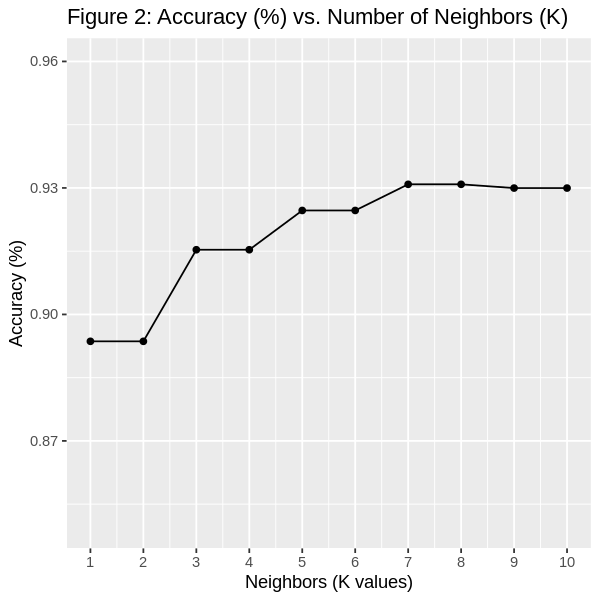

In [40]:
# Visualize the tuning result
options(repr.plot.width=5, repr.plot.height=5)
accuracy_plot <- tuning_result |>
      filter(.metric == "accuracy") |>
      ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors (K values)", y = "Accuracy (%)") +
      scale_x_continuous(breaks = seq(1, 10, by = 1)) +
      scale_y_continuous(limits = c(0.85, 0.96)) +
      ggtitle("Figure 2: Accuracy (%) vs. Number of Neighbors (K)")
accuracy_plot

After visualizing the tuning result (Figure 2), when the model is using 7 or 8 neighbors, it will produce the best accuracy of around 93.0%. Therefore, we decided to use K=7 to train the model.

In [55]:
# pull the final k value
k <- tuning_result |>
    filter(.metric=="accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)

# final knn model
final_knn_spec <- nearest_neighbor(neighbor=k, weight_func="rectangular") |>
    set_mode("classification") |>
    set_engine("kknn")

final_model <- workflow() |>
    add_model(final_knn_spec) |>
    add_recipe(knn_recipe) |>
    fit(data = pulsar_train_downsampled)

### 2.2 Result

Now, the model `final_model` is successfully trained. We need to test its performance on the testing set.

In [62]:
# Predict the testing set.
test_prediction <- predict(final_model, pulsar_test) |>
    bind_cols(pulsar_test)

sprintf("Table 10: ")
head(test_prediction)

# confusion matrix
confusion_matrix <- conf_mat(test_prediction, truth = pulsar_star, estimate = .pred_class)
sprintf("Table 11: ")
confusion_matrix

[1] "Table 10: "

.pred_class,profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
false,140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
false,103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
false,88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
false,93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
false,138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
false,100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


[1] "Table 11: "

          Truth
Prediction false true
     false  4650   51
     true    209  460

In [75]:
# Calculate accuracy, recall, and precision
pulsar_metrics <- metrics(test_prediction, truth=pulsar_star, estimate=.pred_class) |>
    bind_rows(recall(test_prediction, truth=pulsar_star, estimate=.pred_class)) |>
    bind_rows(precision(test_prediction, truth=pulsar_star, estimate=.pred_class))

sprintf("Table 12: ")
pulsar_metrics

[1] "Table 12: "

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9515829
kap,binary,0.7530109
recall,binary,0.9569870
precision,binary,0.9891512


# TODO: Analysis of result

## 3. Discussion

## 4. References